# Import library

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from google.colab import drive
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences, to_categorical, plot_model
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, MultiHeadAttention, Bidirectional, concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K

In [2]:
K.clear_session()

In [3]:
PATH = "/content/drive/My Drive/Colab Notebooks/Python_Notebook/NLP/FinalProject"

In [4]:
drive.mount("/content/drive")
os.chdir(PATH)

Mounted at /content/drive


# Prepare dataset

In [5]:
def read_file(path_file):
  with open(path_file, "r", encoding="utf-8") as f:
    contents = f.readlines()
  return contents

In [6]:
dataFrame = pd.DataFrame({"english": read_file("dataset/en.txt"),
                          "vietnamese": read_file("dataset/vi.txt")})
dataFrame.head(5)

,english,vietnamese
0,rachel pike the science behind a climate headl...,rachel pike khoa_học đằng sau tiêu_đề khí_hậu\n
1,i'd like to talk to you today about the scale ...,hôm_nay tôi muốn nói_chuyện với bạn về quy_mô ...
2,headlines that look like this when they have t...,dòng tiêu_đề trông như thế_này khi liên_quan đ...
3,they are both two branches of the same field o...,cả hai đều là hai nhánh của cùng một lĩnh_vực ...
4,recently the headlines looked like this when t...,gần đây các tiêu_đề trông như thế_này khi ủy_b...


In [7]:
dataFrame.shape

(146148, 2)

In [8]:
print("English: ", dataFrame["english"].iloc[1])
print("Vietnamese: ", dataFrame["vietnamese"].iloc[1])

English:  i'd like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper

Vietnamese:  hôm_nay tôi muốn nói_chuyện với bạn về quy_mô của nỗ_lực khoa_học nhằm tạo ra những tiêu_đề mà bạn thấy trong bài báo



In [9]:
dataFrame["vietnamese"] = dataFrame["vietnamese"].apply(lambda x: "<START> " + x + " <END>")
dataFrame["vietnamese"].head(5)

0    <START> rachel pike khoa_học đằng sau tiêu_đề ...
1    <START> hôm_nay tôi muốn nói_chuyện với bạn về...
2    <START> dòng tiêu_đề trông như thế_này khi liê...
3    <START> cả hai đều là hai nhánh của cùng một l...
4    <START> gần đây các tiêu_đề trông như thế_này ...
Name: vietnamese, dtype: object

# Split train, test and validation dataset

In [10]:
# Train 9:1 and Validation 1:9
TRAIN_RATE = 0.9
VAL_RATE = 0.1

In [11]:
def split_dataset(data, train_rate, validation_rate):
  train_size = int(dataFrame.shape[0] * train_rate)
  validation_size = int(train_size * validation_rate)
  train_data = dataFrame.loc[:train_size-validation_size, :].copy()
  val_data = dataFrame.loc[train_size-validation_size: train_size, :].copy()
  test_data = dataFrame.loc[train_size:, :].copy()
  return train_data, test_data, val_data

In [12]:
train_dataset, test_dataset, val_dataset = split_dataset(dataFrame, train_rate=TRAIN_RATE, validation_rate=VAL_RATE)
print(f"Train shape: {train_dataset.shape}")
print(f"Test shape: {test_dataset.shape}")
print(f"Validation shape: {val_dataset.shape}")

Train shape: (118381, 2)
Test shape: (14615, 2)
Validation shape: (13154, 2)


# Class Language

In [13]:
class Language:
  def __init__(self, documents):
    self.documents = documents
    self.num_docs = 0
    self.tokenizer = None
    self.vocabs = None
    self.vocab_size = 0
    self.max_length = 0
    self.word2idx = None
    self.idx2word = None
    self.__initParams()

  def __initParams(self):
    self.tokenizer = Tokenizer(filters="")
    self.tokenizer.fit_on_texts(self.documents)
    self.vocabs = self.tokenizer.word_index.keys()
    self.num_docs = self.tokenizer.document_count
    self.vocab_size = len(self.vocabs) + 1
    self.max_length = max([len(line.split()) for line in self.documents])
    self.word2idx = self.tokenizer.word_index
    self.idx2word = self.tokenizer.index_word

  def texts_to_sequences(self, data):
    return self.tokenizer.texts_to_sequences(data)

In [14]:
en_lang = Language(dataFrame["english"])
vn_lang = Language(dataFrame["vietnamese"])

# Visualization Data

## English Language

In [15]:
# Vocabulary size
print(f"Vocabulary size: {en_lang.vocab_size}")
# Maximun length sentence
print(f"Maximum length sentence: {en_lang.max_length}")

Vocabulary size: 57339
Maximum length sentence: 49


## Vietnamese Language

In [16]:
# Vocabulary size
print(f"Vocabulary size: {vn_lang.vocab_size}")
# Maximun length sentence
print(f"Maximum length sentence: {vn_lang.max_length}")

Vocabulary size: 40934
Maximum length sentence: 63


# Texts to vectors

In [17]:
# Training data
train_context_vect_inputs = en_lang.texts_to_sequences(train_dataset["english"])
train_target_vect_inputs = vn_lang.texts_to_sequences(train_dataset["vietnamese"])

# Validation data
val_context_vect_inputs = en_lang.texts_to_sequences(val_dataset["english"])
val_target_vect_inputs = vn_lang.texts_to_sequences(val_dataset["vietnamese"])

In [18]:
# Sample in context vector
print("Raw text: ",train_dataset["english"].iloc[0])
print("Text to vector: ", train_context_vect_inputs[0])

Raw text:  rachel pike the science behind a climate headline

Text to vector:  [7749, 21435, 1, 326, 566, 5, 723, 13316]


In [19]:
# Training data
train_context_inputs = pad_sequences(train_context_vect_inputs, maxlen=en_lang.max_length, padding="post")
train_target_inputs = pad_sequences(train_target_vect_inputs, maxlen=vn_lang.max_length, padding="post")

# Validation data
val_context_inputs = pad_sequences(val_context_vect_inputs, maxlen=en_lang.max_length, padding="post")
val_target_inputs = pad_sequences(val_target_vect_inputs, maxlen=vn_lang.max_length, padding="post")

In [20]:
# Sample in context vector
print("Padding vector: ", train_context_inputs[0])

Padding vector:  [ 7749 21435     1   326   566     5   723 13316     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [21]:
train_context_inputs.shape

(118381, 49)

In [ ]:
# Training dataset
train_target_vect_outputs = [vect[1:] for vect in train_target_vect_inputs]
train_target_outputs = pad_sequences(train_target_vect_outputs, maxlen=vn_lang.max_length, padding="post")
print(f"Training shape output: {train_target_outputs.shape}")

# Validation dataset
val_target_vect_outputs = [vect[1:] for vect in val_target_vect_inputs]
val_target_outputs = pad_sequences(val_target_vect_outputs, maxlen=vn_lang.max_length, padding="post")
print(f"Validation shape output: {val_target_outputs.shape}")

Training shape output: (118381, 63)
Validation shape output: (13154, 63)


# Create model
* LSTM + Attention
* BiLSTM + Attention

## Init paramters for model

In [ ]:
UNITS = 256
EMB_DIMS = 128

In [ ]:
checkpoint_filepath = r"checkpoint//bilstm/checkpoint_bilstm_weights"

In [ ]:
early_stopping = EarlyStopping(monitor="loss", min_delta=0.0002, patience=5, mode="auto", restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor="loss", save_weights_only=True, save_best_only=True, mode="auto")

## BiLSTM + Attention

### Encoder and Decoder Layer

In [ ]:
"""ENCODER"""
# Embedding of Encoder Layer
encoder_inputs = Input(shape=(en_lang.max_length, ), name="encoder_input")
encoder_embeds = Embedding(en_lang.vocab_size, EMB_DIMS, mask_zero=True, name="encoder_embedding")(encoder_inputs)
# LSTM of Encoder Layer
encoder_bilstm = Bidirectional(LSTM(UNITS, dropout=0.2, return_sequences=True, return_state=True, name="encoder_lstm"), name="encoder_bilstm")
encoder_outputs, fwd_h, fwd_c, bwd_h, bwd_c = encoder_bilstm(encoder_embeds)
h = concatenate([fwd_h, bwd_h])
c = concatenate([fwd_c, bwd_c])
encoder_states = [h, c]

"""DECODER"""
# Embedding of Decoder Layer
decoder_inputs = Input(shape=(vn_lang.max_length, ), name="decoder_input")
decoder_embeds_layers = Embedding(vn_lang.vocab_size, EMB_DIMS, mask_zero=True, name="decoder_embedding")
decoder_embeds = decoder_embeds_layers(decoder_inputs)

# LSTM of Decoder Layer
decoder_lstm = LSTM(UNITS*2, dropout=0.2, return_sequences=True, return_state=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_embeds, initial_state=encoder_states)

# Attention Layer
attention_layer = MultiHeadAttention(key_dim=UNITS, num_heads=1, name="attention_layer")
attention_sequence, attention_score = attention_layer(query=decoder_outputs, value=encoder_outputs, return_attention_scores=True)

attention_sequence = concatenate([decoder_outputs, attention_sequence])

dense_layer_outputs = Dense(vn_lang.vocab_size, activation="softmax", name="decoder_dense")
outputs = dense_layer_outputs(attention_sequence)

### Model Summary

In [ ]:
bilstm_model = Model([encoder_inputs, decoder_inputs], outputs, name="bilstm")
bilstm_model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
bilstm_model.summary()

Model: "bilstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 49)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 49, 128)      7339392     ['encoder_input[0][0]']          
                                                                                                  
 decoder_input (InputLayer)     [(None, 63)]         0           []                               
                                                                                                  
 encoder_bilstm (Bidirectional)  [(None, 49, 512),   788480      ['encoder_embedding[0][0]']      
                                 (None, 256),                                                

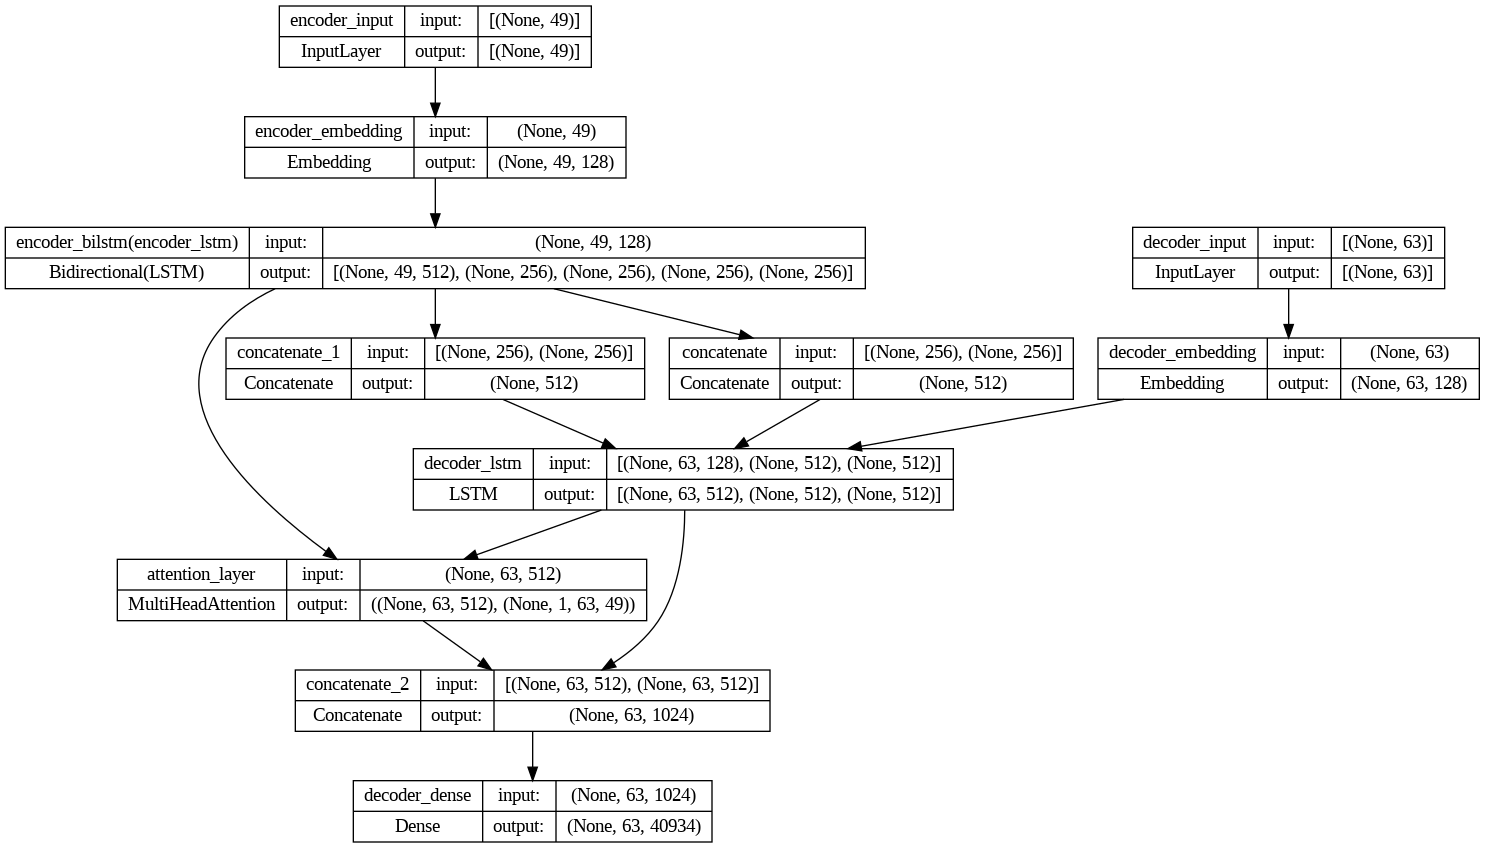

In [ ]:
plot_model(model=bilstm_model, to_file="BiLSTM_model.png", show_shapes=True, show_layer_names=True)

### Train

In [ ]:
history = bilstm_model.fit([train_context_inputs, train_target_inputs], train_target_outputs, \
                              batch_size=128, epochs=150, \
                              validation_data=([val_context_inputs, val_target_inputs], val_target_outputs))

Epoch 1/150
925/925 [==============================] - 275s 275ms/step - loss: 6.1486 - accuracy: 0.1247 - val_loss: 5.8033 - val_accuracy: 0.1560
Epoch 2/150
925/925 [==============================] - 215s 232ms/step - loss: 5.4725 - accuracy: 0.1866 - val_loss: 5.2362 - val_accuracy: 0.2172
Epoch 3/150
925/925 [==============================] - 211s 228ms/step - loss: 4.9343 - accuracy: 0.2537 - val_loss: 4.6908 - val_accuracy: 0.2914
Epoch 4/150
925/925 [==============================] - 209s 226ms/step - loss: 4.2672 - accuracy: 0.3452 - val_loss: 3.8681 - val_accuracy: 0.4049
Epoch 5/150
925/925 [==============================] - 209s 226ms/step - loss: 3.5366 - accuracy: 0.4414 - val_loss: 3.3099 - val_accuracy: 0.4765
Epoch 6/150
925/925 [==============================] - 209s 226ms/step - loss: 3.0299 - accuracy: 0.5018 - val_loss: 2.9791 - val_accuracy: 0.5190
Epoch 7/150
925/925 [==============================] - 208s 225ms/step - loss: 2.6699 - accuracy: 0.5436 - val_loss: 2

In [ ]:
drive.mount("/content/drive")
os.chdir(PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Save Model

In [ ]:
bilstm_model.save("models/BiLSTM/model_BiLSTM_Machine_Translation.h5")

### Inference Model

In [ ]:
def inference_model():
    # ENCODER model
    encoder_model = Model(encoder_inputs, [encoder_outputs] + encoder_states)

    # DECODER model
    # State inputs of Decoder layer
    state_h_inputs = Input(shape=(UNITS*2, ))
    state_c_inputs = Input(shape=(UNITS*2, ))
    states_inputs = [state_h_inputs, state_c_inputs]
    decoder_outputs, h, c = decoder_lstm(decoder_embeds, initial_state=states_inputs)

    decoder_encoder_inputs = Input(batch_shape=(None, en_lang.max_length, UNITS*2))
    attention_sequence, attention_score = attention_layer(query=decoder_outputs, value=decoder_encoder_inputs, return_attention_scores=True)
    attention_sequence = concatenate([decoder_outputs, attention_sequence])

    dense_output = dense_layer_outputs(attention_sequence)

    decoder_model = Model([decoder_encoder_inputs, decoder_inputs] + states_inputs,
                                [dense_output, attention_score, h, c])
    return encoder_model, decoder_model

In [ ]:
encoder_model, decoder_model = inference_model()

In [ ]:
encoder_model.save("models/BiLSTM/encoder_model.h5")
decoder_model.save("models/BiLSTM/decoder_model.h5")

### Encoder Model

In [22]:
encoder_model = load_model("models/BiLSTM/encoder_model.h5")

In [23]:
encoder_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 49)]         0           []                               
                                                                                                  
 encoder_embedding (Embedding)  (None, 49, 128)      7339392     ['encoder_input[0][0]']          
                                                                                                  
 encoder_bilstm (Bidirectional)  [(None, 49, 512),   788480      ['encoder_embedding[0][0]']      
                                 (None, 256),                                                     
                                 (None, 256),                                                     
                                 (None, 256),                                                 

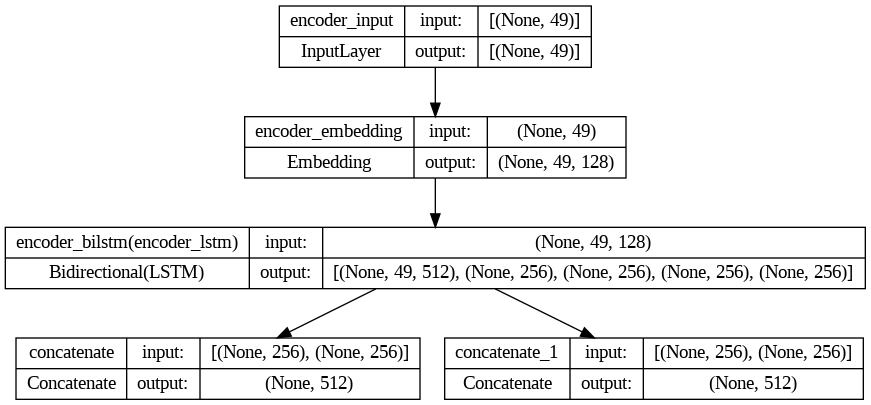

In [24]:
plot_model(model=encoder_model, show_shapes=True, show_layer_names=True)

### Decoder Model

In [25]:
decoder_model = load_model("models/BiLSTM/decoder_model.h5")

In [26]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 63)]         0           []                               
                                                                                                  
 decoder_embedding (Embedding)  (None, 63, 128)      5239552     ['decoder_input[0][0]']          
                                                                                                  
 input_1 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

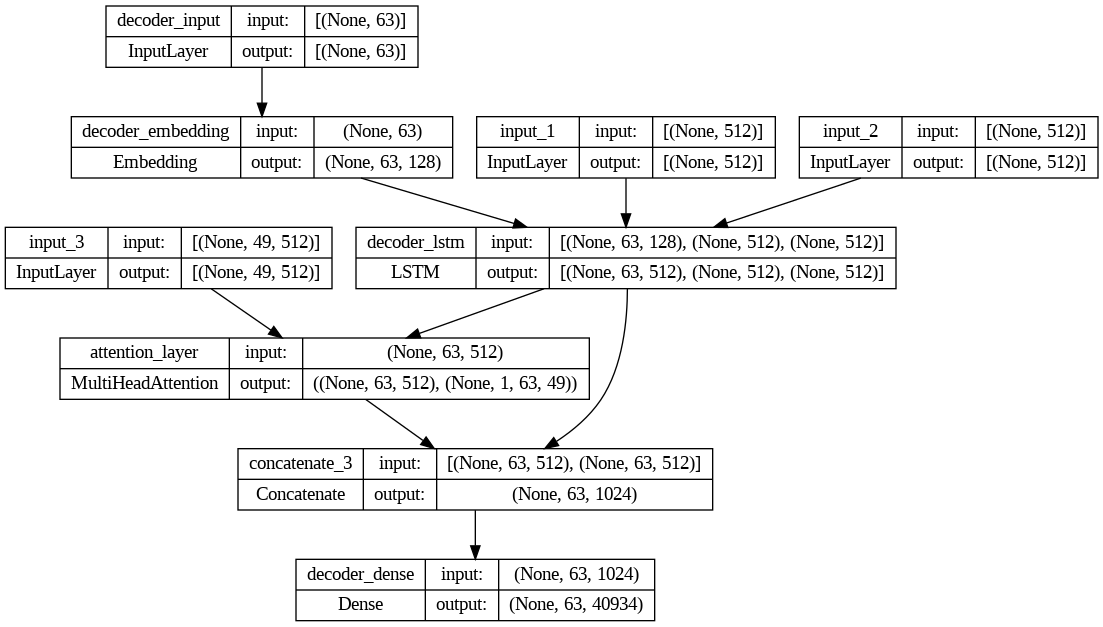

In [27]:
plot_model(model=decoder_model, show_shapes=True, show_layer_names=True)

### Translate

In [28]:
def translate(text):
    # Preprecessing
    text = en_lang.tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=en_lang.max_length, padding="post")
    
    empty_seq = np.zeros((1, 1))
    empty_seq[0, 0] = vn_lang.word2idx["<start>"]
    target = []
    
    inputs, h, c = encoder_model.predict(text, verbose=None)
    states = [h, c]
    for _ in range(vn_lang.max_length):
        outputs, attn_scores, h, c = decoder_model.predict([inputs, empty_seq] + states, verbose=None)
        idx = np.argmax(outputs[0, -1, :])
        word = vn_lang.idx2word[idx]
        target.append(word)
        if word == "<end>":
            break
        empty_seq[0, 0] = idx
        states = [h, c]
    return " ".join(target)

### Result

In [29]:
import textwrap
wrapper = textwrap.TextWrapper(width=100)

In [30]:
for i in range(10):
  example = test_dataset.iloc[i]
  print("Context: {}".format(wrapper.fill(example["english"])))
  print("True Target: {}".format(wrapper.fill(example["vietnamese"])))
  print("Predict: {}".format(wrapper.fill(translate(example["english"]))))
  print("="*120)

Context: and i want to talk to you about that because even more than giving is the capacity for us to do
something smarter together for the greater good that lifts us both up and that can scale
True Target: <START> và tôi muốn nói với bạn về điều đó bởi_vì thậm_chí nhiều hơn là cho đi là khả_năng chúng_ta
cùng nhau làm điều gì đó thông_minh hơn vì lợi_ích lớn hơn nâng cả hai chúng_ta lên và điều đó
có_thể mở_rộng  <END>
Predict: và tôi muốn nói với bạn về điều đó bởi_vì thậm_chí còn tạo ra là khả_năng để chúng_ta làm điều gì đó
thông_minh hơn cho đến điều tốt_đẹp hơn nâng cao hơn nâng hết con_người này lên và có_thể mở_rộng
quy_mô  <end>
Context: that's why i'm sitting here
True Target: <START> đó là lý_do tại_sao tôi ngồi đây  <END>
Predict: thật là lý_do tại_sao tôi đang ngồi đây  <end>
Context: but i also want to point something else out each one of you is better than anybody else at something
True Target: <START> nhưng tôi cũng muốn chỉ ra một điều khác mỗi người trong số các bạn đ

## BLEU score

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
def bleu_score(sources, targets):
    actual, predicted = [], []
    for i, source in enumerate(sources):
        try:
          translation = translate(source)
          raw_target = targets.iloc[i][8:].lower()
          actual.append([raw_target.split()])
          predicted.append(translation.split())
        except:
          pass
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

In [ ]:
# Compute the BLEU Score
bleu_train = bleu_score(train_dataset["english"].iloc[:100], train_dataset["vietnamese"].iloc[:100])
bleu_test = bleu_score(test_dataset["english"].iloc[:100], test_dataset["vietnamese"].iloc[:100])

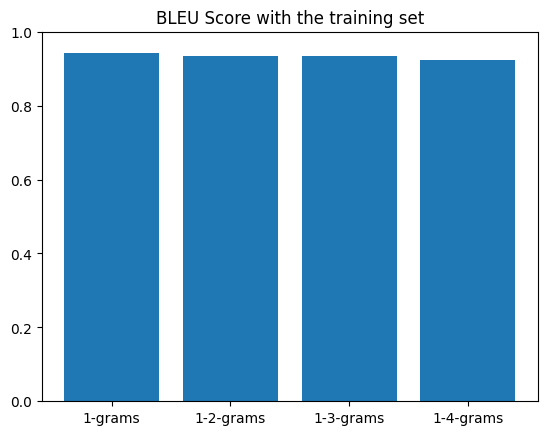

In [ ]:
plt.bar(x = bleu_train.keys(), height = bleu_train.values())
plt.title("BLEU Score with the training set")
plt.ylim((0,1))
plt.show()

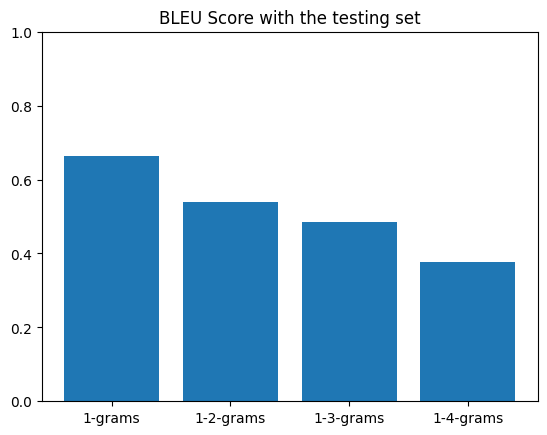

In [ ]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the testing set")
plt.ylim((0,1))
plt.show()